In [47]:
import pandas
import tqdm
from scipy.optimize import curve_fit
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pickle
from functools import partial
from os import listdir
from os.path import isfile, join

import numpy as np
import scipy
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit

import graph_generator
from common import CityResult,CentroidResult
from file_name_generator import generate_new_name



In [49]:
mypath = './'

r : dict[str:CityResult]= {}

with open(join(mypath, 'PARIS_1.pkl'), 'rb') as f:
    r['paris'] = pickle.load(f)
    f.close()

In [51]:
res: CityResult = r['paris']

In [52]:
paris_alpha = [p.alpha for p in res.points_results]
paris_speed_up = [p.speed_up[0] for p in res.points_results]


In [3]:
df = pd.read_csv('data (3)')

df

,Unnamed: 0,alpha,s1,s2,s3
0,0,0.002002,0.009974,0.060457,2.182617
1,1,0.027918,0.090323,0.017795,0.482405
2,2,0.054888,0.173755,0.015277,0.338432
3,3,0.082174,0.254375,0.013969,0.266878
4,4,0.109250,0.390808,0.013723,0.240625
5,5,0.137484,0.450292,0.013347,0.206835
6,6,0.164981,0.527589,0.013028,0.186959
7,7,0.191740,0.630950,0.013973,0.177029
8,8,0.218184,0.704555,0.013811,0.155242
9,9,0.244732,0.784836,0.014052,0.148209


[3.51852079]
[0.09364747]


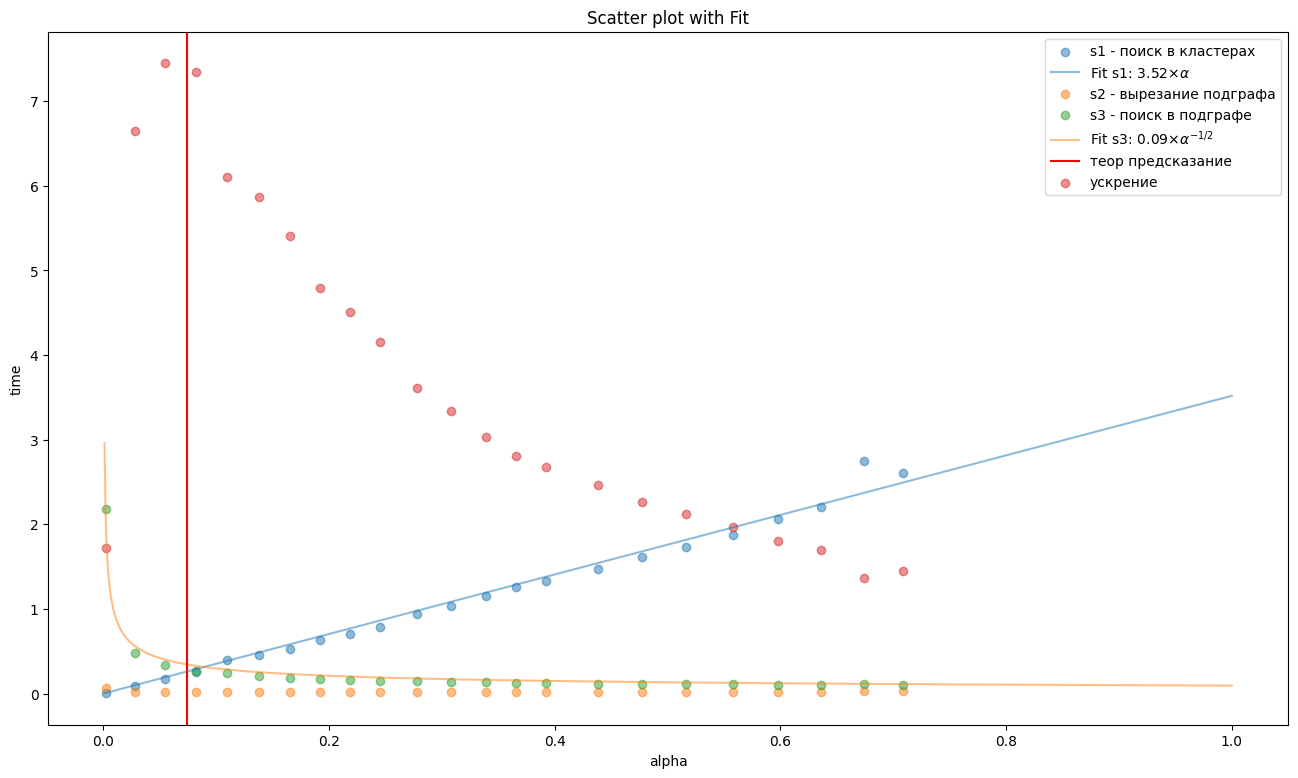

In [57]:
xx = np.linspace(1/1000,1,1000)

def s1(x,a):
    return a*x

def s3(x,a):
    return a/np.sqrt(x)
    

# Построение графика
plt.figure(figsize=(16, 9))
plt.scatter(df['alpha'], df['s1'], alpha=0.5, label='s1 - поиск в кластерах')
popt = curve_fit(s1, df['alpha'], df['s1'])
print(popt[0])
plt.plot(xx, s1(xx, *popt[0]), alpha=0.5, label=r'Fit s1: {:.2f}$\times \alpha$'.format(popt[0][0]))

plt.scatter(df['alpha'], df['s2'], alpha=0.5, label='s2 - вырезание подграфа')


plt.scatter(df['alpha'], df['s3'], alpha=0.5, label='s3 - поиск в подграфе')
popt = curve_fit(s3, df['alpha'], df['s3'])
print(popt[0])
plt.plot(xx, s3(xx, *popt[0]), alpha=0.5,  label=r'Fit s3: {:.2f}$\times \alpha^{{-1/2}}$'.format(popt[0][0]))
a = (4/10000) ** (1/3)
plt.axvline(x=a,c='r', label = 'теор предсказание')

plt.scatter(paris_alpha,paris_speed_up, alpha=0.5, label='ускрение')


plt.xlabel('alpha')
plt.ylabel('time')
plt.title('Scatter plot with Fit')
plt.legend()
plt.show()


In [41]:
from tqdm import trange

alpha = []
NODES = []

for N in trange(1000,80000,1000):
    def func(x):
        return 1/(x * (1 + np.log(x)/np.log(N)) + 2/np.sqrt(x * N) * (1 - np.log(x)/np.log(N)) + 1/np.sqrt(x * N) /np.log(N)) 
    
    xx = np.linspace(1/N,1,100000)
    yy = func(xx)
    
    NODES.append(N)
    alpha.append(xx[np.argmax(yy)])


100%|██████████| 79/79 [00:00<00:00, 249.93it/s]


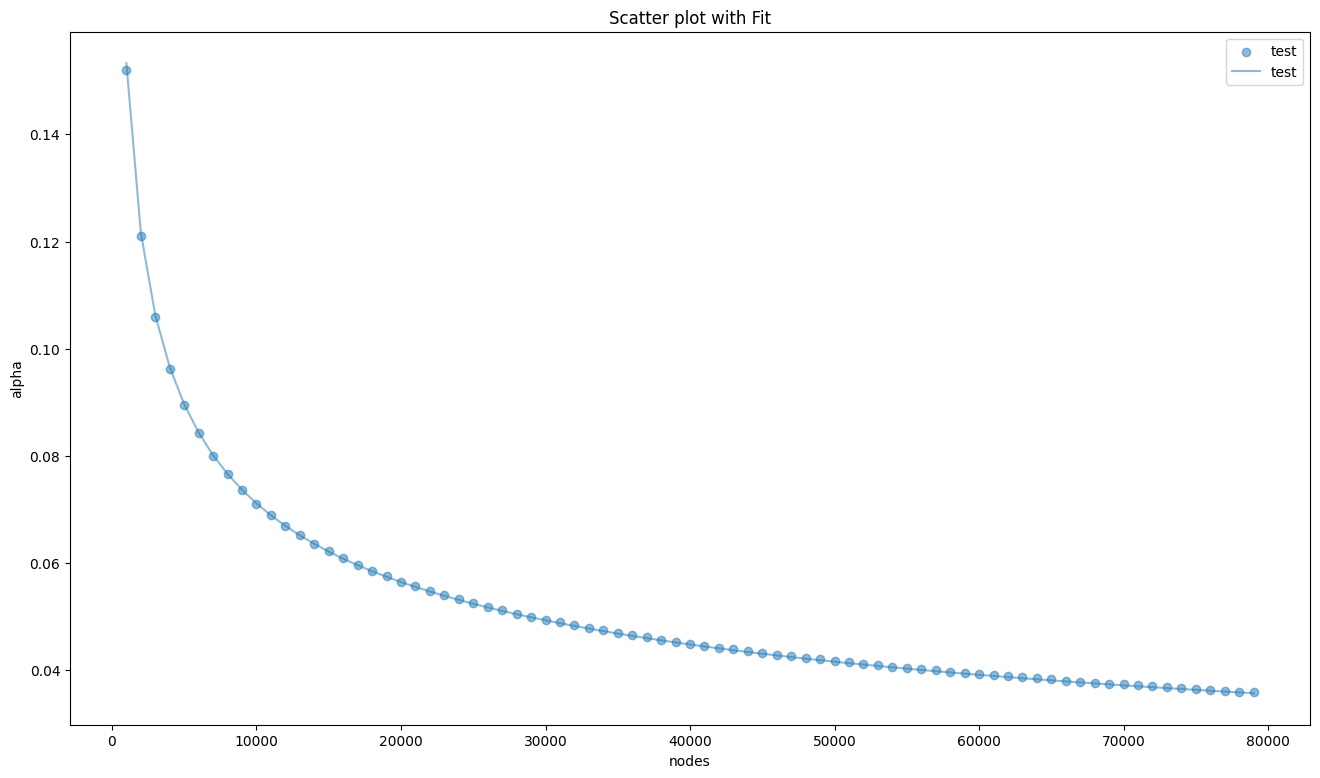

In [42]:
def func(x,a):
    return a * x ** (-1/3)

NODES = np.array(NODES)

plt.figure(figsize=(16, 9))
plt.scatter(NODES, alpha, alpha=0.5, label='test')
popt = curve_fit(func, NODES, alpha)
plt.plot(NODES, func(NODES, *popt[0]), alpha=0.5, label='test')

plt.xlabel('nodes')
plt.ylabel('alpha')
plt.title('Scatter plot with Fit')
plt.legend()
plt.show()

In [3]:
def test_graph(graph: nx.Graph, name: str, city_id: str, points: list[tuple[int, int]] = None,
               resolutions: list[float] = None, pos=2, logs=True, alg='dijkstra') -> CityResult:
    max_alpha = 1 if resolutions is None else max(resolutions)
    delta = max_alpha / 40
    if resolutions is None:
        resolutions = []
        resolutions += [i / 10 for i in range(1, 10, 1)]
        resolutions += [i for i in range(1, 10, 1)]
        resolutions += [i for i in range(10, 50, 2)]
        resolutions += [i for i in range(50, 100, 5)]
        resolutions += [i for i in range(100, 500, 10)]
        resolutions += [i for i in range(500, 1000, 50)]
        resolutions += [i for i in range(1000, 5000, 200)]
    if points is None:
        N: int = 1000
        points = [get_node_for_initial_graph_v2(graph) for _ in trange(N, desc='generate points')]
    else:
        N = len(points)

    has_coords = 'x' in [d for u, d in graph.nodes(data=True)][0]

    usual_results = get_usual_result(graph, points, alg=alg)

    data = {
        
    }

    alphas = set()
    for r in resolutions:
        start = time.time()
        community = graph_generator.resolve_communities(graph, r)
        # print(len(community) / len(graph.nodes))
        if len(community) < 5:
            continue
        a = len(community) / len(graph.nodes)
        has = False
        for curr in alphas:
            if abs(curr - a) < delta:
                has = True
                break
        if has or a > max_alpha:
            if logs:
                tqdm.write(f'alpha: {a} -- skip')
            if a == 1 and 1 in alphas or a > max_alpha:
                break
            else:
                continue
        alphas.add(a)
        layer, build_communities, build_additional, build_centroid_graph = generate_layer(graph, r,
                                                                                          has_coordinates=has_coords,
                                                                                          communities=community)
        tmp = test_layer(points, layer, alg=alg)
        total = time.time() - start
        text = """
                name:           {}
                alpha:          {:4f}
                total time:     {:.3f}
                prepare time:   {:.3f} 
                    build_communities:      {:.3f}
                    build_additional:       {:.3f}
                    build_centroid_graph:   {:.3f}
                pfa time:       {:.3f}
            """.format(name, a, total, total - tmp[0], build_communities, build_additional, build_centroid_graph,
                       tmp[0])
        if logs:
            tqdm.write(text)
        result.points_results.append(generate_result(usual_results, tmp, r, layer))


    result.save()
    if logs:
        s = [p.speed_up[0] for p in result.points_results]
        indx = np.argmax(s)
        max_s = s[indx]
        print(alg + ' usual time:', result.points_results[indx].absolute_time[0] * max_s)
        print(alg + ' hpfa time:', result.points_results[indx].absolute_time[0])
        print(alg + ' max_speedUp:', max(s))
        print(alg + ' mean_err:', np.mean(result.points_results[np.argmax(s)].errors),
              np.std(result.points_results[0].errors))
        print(alg + ' max_err:', np.max(result.points_results[np.argmax(s)].errors))
    return result
def test_graph(graph: nx.Graph, name: str, city_id: str, points: list[tuple[int, int]] = None,
               resolutions: list[float] = None, pos=2, logs=True, alg='dijkstra') -> CityResult:
    max_alpha = 1 if resolutions is None else max(resolutions)
    delta = max_alpha / 40
    if resolutions is None:
        resolutions = []
        resolutions += [i / 10 for i in range(1, 10, 1)]
        resolutions += [i for i in range(1, 10, 1)]
        resolutions += [i for i in range(10, 50, 2)]
        resolutions += [i for i in range(50, 100, 5)]
        resolutions += [i for i in range(100, 500, 10)]
        resolutions += [i for i in range(500, 1000, 50)]
        resolutions += [i for i in range(1000, 5000, 200)]
    if points is None:
        N: int = 1000
        points = [get_node_for_initial_graph_v2(graph) for _ in trange(N, desc='generate points')]
    else:
        N = len(points)

    has_coords = 'x' in [d for u, d in graph.nodes(data=True)][0]

    usual_results = get_usual_result(graph, points, alg=alg)

    data = {
        
    }

    alphas = set()
    for r in resolutions:
        start = time.time()
        community = graph_generator.resolve_communities(graph, r)
        # print(len(community) / len(graph.nodes))
        if len(community) < 5:
            continue
        a = len(community) / len(graph.nodes)
        has = False
        for curr in alphas:
            if abs(curr - a) < delta:
                has = True
                break
        if has or a > max_alpha:
            if logs:
                tqdm.write(f'alpha: {a} -- skip')
            if a == 1 and 1 in alphas or a > max_alpha:
                break
            else:
                continue
        alphas.add(a)
        layer, build_communities, build_additional, build_centroid_graph = generate_layer(graph, r,
                                                                                          has_coordinates=has_coords,
                                                                                          communities=community)
        tmp = test_layer(points, layer, alg=alg)
        total = time.time() - start
        text = """
                name:           {}
                alpha:          {:4f}
                total time:     {:.3f}
                prepare time:   {:.3f} 
                    build_communities:      {:.3f}
                    build_additional:       {:.3f}
                    build_centroid_graph:   {:.3f}
                pfa time:       {:.3f}
            """.format(name, a, total, total - tmp[0], build_communities, build_additional, build_centroid_graph,
                       tmp[0])
        if logs:
            tqdm.write(text)
        result.points_results.append(generate_result(usual_results, tmp, r, layer))


    result.save()
    if logs:
        s = [p.speed_up[0] for p in result.points_results]
        indx = np.argmax(s)
        max_s = s[indx]
        print(alg + ' usual time:', result.points_results[indx].absolute_time[0] * max_s)
        print(alg + ' hpfa time:', result.points_results[indx].absolute_time[0])
        print(alg + ' max_speedUp:', max(s))
        print(alg + ' mean_err:', np.mean(result.points_results[np.argmax(s)].errors),
              np.std(result.points_results[0].errors))
        print(alg + ' max_err:', np.max(result.points_results[np.argmax(s)].errors))
    return result
def calculate(data):
    cities = data[0]
    points_number = data[1]
    NUMBER = data[2]
    THREADS = data[3]

    for name, id in tqdm(cities, position=NUMBER):
        G = get_graph(id)

        points = [graph_generator.get_node_for_initial_graph_v2(G) for _ in
                  range(points_number)]

        Q = G.copy()
        for u in Q.nodes:
            if u in Q[u]:
                Q.remove_edge(u, u)
        test_graph(Q,
                              f'{name}',
                              id,
                              points=points, pos=NUMBER, logs=False)

In [4]:
total = 2
points_number = 500

cities = {
        # 'ASHA': 'R13470549',
        # 'KRG': 'R4676636',
        # 'EKB': 'R6564910',
        # 'BARCELONA': 'R347950',
        'PARIS': 'R71525',
        # 'Prague': 'R435514',
        # 'MSK': 'R2555133',
        # 'SBP': 'R337422',
        # 'SINGAPORE': 'R17140517',
        # 'BERLIN': 'R62422',
        # 'ROME': 'R41485',
        # 'LA': 'R207359',
        # 'DUBAI': 'R4479752',
        # 'RIO': 'R2697338',
        # 'DELHI': 'R1942586',
        # 'KAIR': 'R5466227'
}

total_len = len(cities)
l = list(cities.items())
data = [[l[i: total_len: total], points_number, i + 1, total] for i in range(total)]

calculate(data[0])

2



  0%|          | 0/1 [00:07<?, ?it/s]

KeyboardInterrupt

